In [66]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import pandas as pd
seaborn.set_context('talk'); plt.style.use('ggplot')

In [3]:
years = [1972, 1976, 1977, 1979, 1982, 1987, 1987, 1994, 1995, 1997, 1999, 2001, 2002, 2005, 2006, 2009, 2011, 2014, 2018]
 
sram = [1280, 435, 1120, 1740, 951.7, 220, 111, 44, 18.1, 10.26, 5.5, 2.09, 1.0, 0.570, 0.346, 0.148, 0.092, 0.0499, 0.0312]
 
processName = [8, 5, 3, 2, 1.5, 1, .8, .5, .35, .25, .18, .13, .09, .065, .045, .032, .022, .014, .01]
 
gateLength = [8, 5, 3, 2, 1.5, 1, .8, .5, .35, .2, .13, .06, .05, .035, .035, .03, .026, .02, .02]
 
metalLayers = [1, 1, 1, 1, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13]

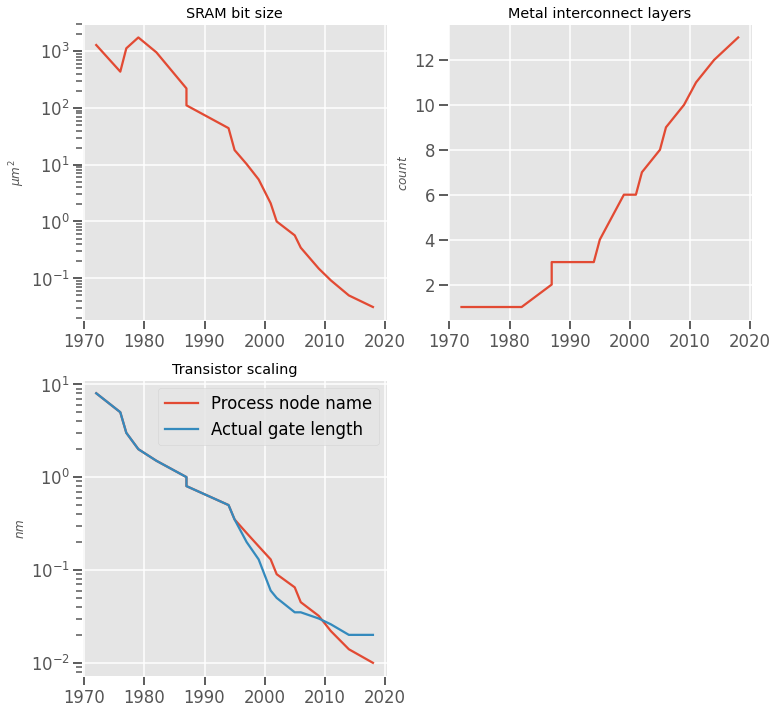

In [38]:
plt.figure(figsize=(12,12))
p=plt.subplot(2,2,1)
plt.plot(years,sram)
plt.yscale("log")
plt.ylabel("$μm^2$")
plt.title("SRAM bit size")

plt.subplot(2,2,2,sharex=p)
plt.plot(years,metalLayers)
plt.ylabel("$count$")
plt.title("Metal interconnect layers")


plt.subplot(2,2,3,sharex=p)
plt.plot(years,processName,label="Process node name")
plt.ylabel("$nm$")
plt.yscale("log")
plt.title("Transistor scaling")
plt.plot(years,gateLength,label="Actual gate length")
plt.legend()
plt.savefig("semi.svg")

In [74]:
import datetime

In [73]:
pd.DataFrame([{"name":"Intel Core i9-9900KS","score":1413,"released":"2019-10-30"},
             {"name":"Intel Core i7-8750H","score":1004,"released":"2018-04-02"},
              # Can't get exact release day, so mid june
              {"name":"Intel Core i9-7900X","score":1133,"released":"2017-06-15"},
             {"name":"Intel Core i7-920","score":468,"released":"2008-11-01"}])

,name,score,released
0,Intel Core i9-9900KS,1413,2019-10-30
1,Intel Core i7-8750H,1004,2018-04-02
2,Intel Core i9-7900X,1133,2017-06-15
3,Intel Core i7-920,468,2008-11-01


In [83]:
def cagr(start,end,years):
    return 100*((end/start)**(1/years)-1)

In [84]:
# For the i9
years=(datetime.datetime(2019,10,30)-datetime.datetime(2017,6,15)).days/365
cagr(1133,1413,years)

9.743367808030312

In [85]:
# For the i7
years=(datetime.datetime(2018,4,2)-datetime.datetime(2008,11,1)).days/365
cagr(468,1004,years)

8.438282710295253

In [86]:
from bs4 import BeautifulSoup
r=requests.get("https://www.spec.org/cpu2017/results/cfp2017.html")
soup = BeautifulSoup(r.content)

In [95]:
csvs=[]
for link in soup.find_all("a",href=True):
    if "csv" in link['href']:
        csvs.append("https://www.spec.org/cpu2017/results/"+link['href'])

In [97]:
from multiprocessing.pool import ThreadPool
pool=ThreadPool(50)
all_csvs=pool.map(requests.get,csvs)

In [134]:
def parse_one(csv):
    ret={}
    for line in csv.content.decode().split("\n"):

        if "CPU Name" in line:
            cpuname=line.split(",")[1][1:-1]
            ret["cpuname"]=cpuname
        if "Hardware avail" in line:
            ret["releasedate"]=pd.to_datetime(line.split(",")[1])
        if "SPECspeed2017_fp_peak" in line:
            try:
                ret["score"]=float(line.split(",")[-1])
            except:
                ret["score"]=None
    return ret


In [135]:
parsed=[parse_one(i) for i in all_csvs]

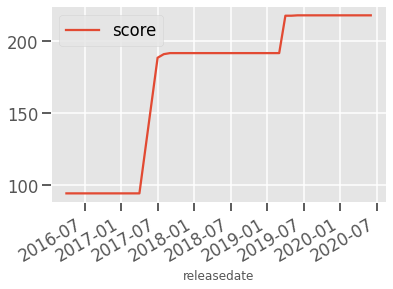

In [164]:
(pd.DataFrame(parsed)
 .dropna()[['score','releasedate']]
 .groupby("releasedate").max().expanding().max()
).plot()

In [149]:
pd.DataFrame(parsed).score.max()

217.571943

In [173]:
def get_fastest(g):
    return g.iloc[-1]
    0/0
(pd.DataFrame(parsed)
 .dropna()[['score','releasedate']].assign(releasedate=lambda x: x.releasedate.dt.year)
 .sort_values("score")
 .groupby("releasedate").apply(get_fastest)
)

,score,releasedate
releasedate,,
2016,94.466315,2016.0
2017,191.452875,2017.0
2018,182.018089,2018.0
2019,217.571943,2019.0
2020,201.588272,2020.0


In [176]:
(pd.DataFrame(parsed)
 .dropna().assign(releasedate=lambda x: x.releasedate.dt.year).query("releasedate==2016")
 .sort_values("score"))

,score,releasedate,cpuname
1091,6.658511,2016,Intel Xeon E7-8890 v4
1092,7.605833,2016,Intel Xeon E5-2699 v4
2431,94.466315,2016,Intel Xeon E5-2699A v4


In [189]:
years=((pd.DataFrame(parsed)).query("cpuname in['Intel Xeon Platinum 9282','Intel Xeon E5-2699A v4']").releasedate
.diff().abs().dt.days.max()/365)
print(years)

3.1671232876712327


In [190]:
cagr(94.46,201.588,years)

27.042254017046897